In [202]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [203]:
pdb = '/home/daisy/Documents/Chem_course/Chem101.6/Assignment4/2F4K.protein.pdb'
trajectory = '/home/daisy/Documents/Chem_course/Chem101.6/Assignment4/2F4K.protein.s10.dcd'
xray_CA_pdb = '/home/daisy/Documents/Chem_course/Chem101.6/Assignment4/2f4K.xray.CA.pdb'
outdir = '/home/daisy/Documents/Chem_course/Chem101.6/Assignment4/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')

print("outdir:", outdir)
print("pdb:", pdb)
print("trjaectory:", trajectory)


outdir: /home/daisy/Documents/Chem_course/Chem101.6/Assignment4/output
pdb: /home/daisy/Documents/Chem_course/Chem101.6/Assignment4/2F4K.protein.pdb
trjaectory: /home/daisy/Documents/Chem_course/Chem101.6/Assignment4/2F4K.protein.s10.dcd


In [204]:
stride_sel = 10
trj = md.load(trajectory, top=pdb, stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
trj_length = 125
time = np.linspace(0, 125, n_frames)


In [205]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
res_num = (' %s' % [residue.resSeq for residue in trj.topology.residues])
res_code = (' %s' % [residue.code for residue in trj.topology.residues])


#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)
print("residue code: %s" % res_code)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [206]:
res_code = [residue.code for residue in trj.topology.residues]
"".join([residue.code for residue in trj.topology.residues])


'LSDEDFKAVFGMTRSAFANLPLWLQQHLLKEKGLFLSDEDFKAVFGMTRSAFANLPLWLQQHLLKEKGLF'

In [207]:
residue_num = []
for res in top.residues:
    residue_num.append(res.resSeq)
residue_id = np.asarray(residue_num)


In [208]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray = []
for res in top_xray.residues:
    residue_xray.append(res.resSeq)
resid_xray = np.asarray(residue_xray)
resid_xray


array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [209]:
# Use DSSP to calculate the secondary structure definition
# https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb, stride=stride_sel)
BB = top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp = md.compute_dssp(trjBB, simplified=True)


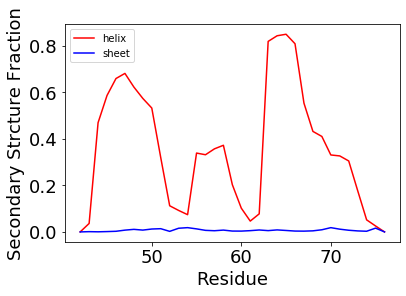

In [210]:
# dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    Hprop = np.sum(dsspH, axis=0).astype(float)/len(dsspE)

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    return Hprop, Eprop


Hprop, Eprop = dssp_convert(dssp)
plt.plot(resid_xray, Hprop, c='r', label='helix')
plt.plot(resid_xray, Eprop, c='b', label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [211]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]


In [212]:
phi_dict = {}
dihedral_dict = {'phi': {},
                 'psi': {},
                 'chi1': {},
                 'chi2': {}}

for i in range(0, len(indices_phi)):
    indices = indices_phi[i]
    atom = top.atom(indices[1])
    resnum = top.atom(indices[1]).residue.resSeq
    dihedral_dict['phi'][resnum] = phis[:, i]

for i in range(0, len(indices_psi)):
    indices = indices_psi[i]
    atom = top.atom(indices[1])
    resnum = top.atom(indices[1]).residue.resSeq
    dihedral_dict['psi'][resnum] = psis[:, i]

for i in range(0, len(indices_chi1)):
    indices = indices_chi1[i]
    atom = top.atom(indices[1])
    resnum = top.atom(indices[1]).residue.resSeq
    dihedral_dict['chi1'][resnum] = chi1s[:, i]

for i in range(0, len(indices_chi2)):
    indices = indices_chi2[i]
    atom = top.atom(indices[1])
    resnum = top.atom(indices[1]).residue.resSeq
    dihedral_dict['chi2'][resnum] = chi2s[:, i]


In [213]:
# Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
    plt.hist2d(dihedral_dict['phi'][res], dihedral_dict['psi'][res], bins=36, range=[
               [-3.14, 3.14], [-3.14, 3.14]], norm=colors.LogNorm(), cmap='jet')
    plt.xlabel('$\phi$', size=18)
    plt.ylabel('$\psi$', size=18)
    plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
    plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
    plt.tick_params(labelsize=18)
    plt.show()
    return


def plot_chi(res):
    if res in dihedral_dict['chi1']:
        plt.hist(dihedral_dict['chi1'][res], bins=36, range=[-3.14, 3.14])
        plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.xlabel('$\chi_1$', size=18)
        plt.ylabel('counts', size=18)
        plt.tick_params(labelsize=18)
        plt.show()
        plt.clf()
    if res in dihedral_dict['chi2']:
        plt.hist2d(dihedral_dict['chi1'][res], dihedral_dict['chi2'][res], bins=36, range=[
                   [-3.14, 3.14], [-3.14, 3.14]], norm=colors.LogNorm(), cmap='jet')
        plt.xlabel('$\chi_1$', size=18)
        plt.ylabel('$\chi_2$', size=18)
        plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.tick_params(labelsize=18)
        plt.show()
    return


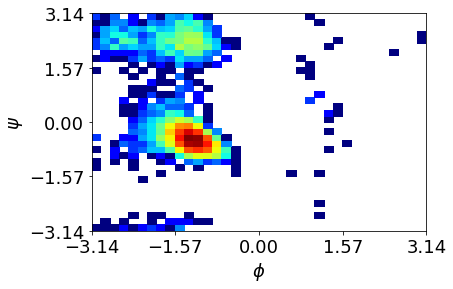

In [214]:
plot_phipsi(45)


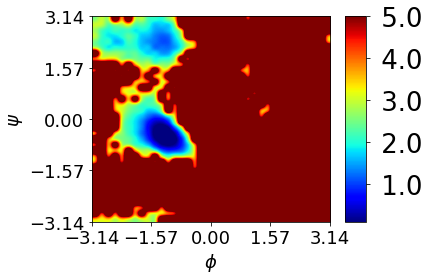

In [215]:
def plot_phipsi_FES(res):
    free_energy, xedges, yedges = np.histogram2d(dihedral_dict['psi'][res], dihedral_dict['phi'][res], 36, [
                                                 [-3.14, 3.14], [-3.14, 3.14]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    T = 300
    kbT = T*0.008314/4.184  # kT in kcal/mol
    dG = -(kbT)*free_energy  # Convert to kcal/mol
    im = plt.imshow(dG, interpolation='gaussian', extent=[
                    yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
    cbar_ticks = [0, 1, 2, 3, 4, 5]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                      aspect=10)  # grab the Colorbar instance
    imaxes = plt.gca()
    plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
    plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
    plt.xlabel('$\phi$', size=18)
    plt.ylabel('$\psi$', size=18)
    plt.tick_params(labelsize=18)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=5.0)
    plt.yticks(size='26')
    plt.tight_layout()
    plt.show()
    return


plot_phipsi_FES(45)


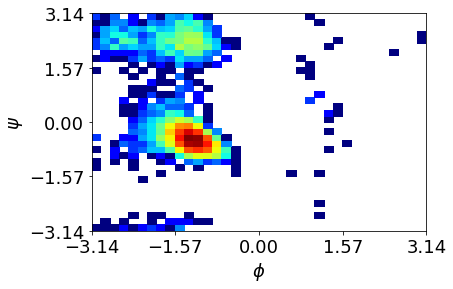

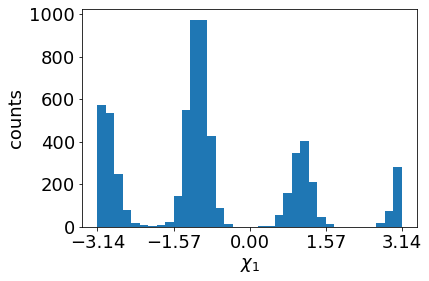

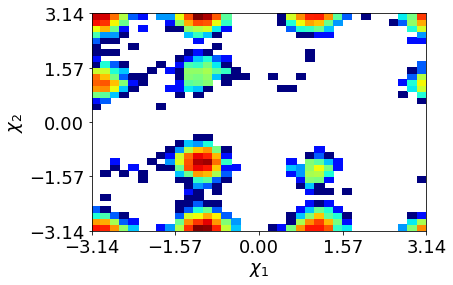

In [216]:
plot_phipsi(45)
plt.clf()
plot_chi(45)


In [217]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray = []
for res in top.residues:
    residue_xray.append(res.resSeq)
resid_xray = np.asarray(residue_xray)
resid_xray


array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [218]:
trjCA = md.load(trajectory, top=pdb, stride=stride_sel)
CA = top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()


<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x7fe5f5517f98>

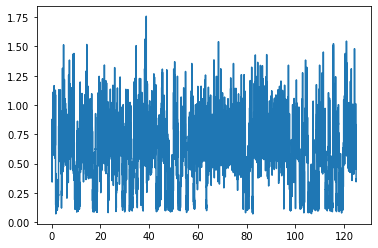

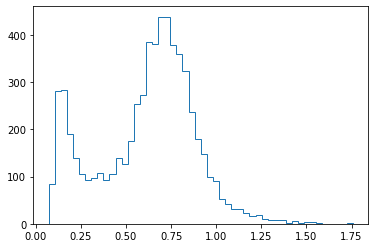

In [219]:
CA_trj_sel = trj.topology.select("name CA")
CA_xray_sel = xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA, xray_CA)
plt.plot(time, rmsd)
plt.show()
plt.clf()

plt.hist(rmsd, histtype='step', bins=50)
plt.show()


In [220]:
native_frames = np.where(rmsd < 0.25)[0]
len(native_frames)


1016

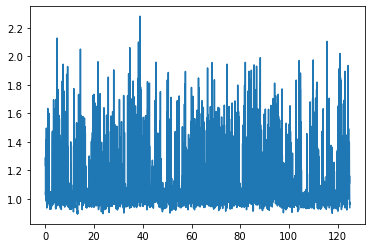

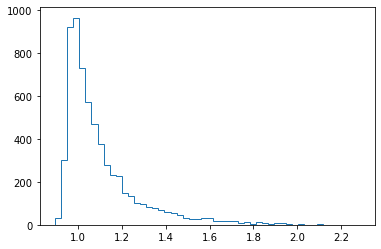

In [221]:
# Lets calculate the radius of gyration
rg = md.compute_rg(trj, masses=None)
plt.plot(time, rg)
plt.show()
plt.clf()

plt.hist(rg, histtype='step', bins=50)
plt.show()


In [222]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(
    trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)


(6280, 2)


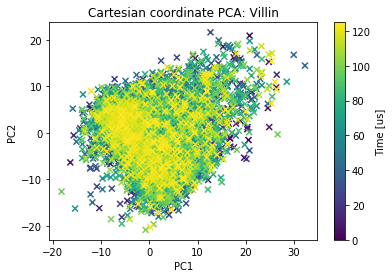

In [223]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0],
            reduced_cartesian[:, 1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')


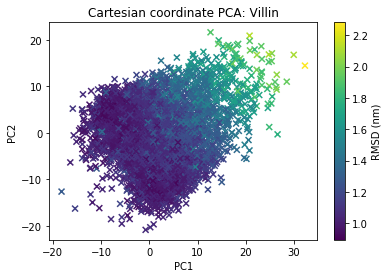

In [224]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:, 1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')


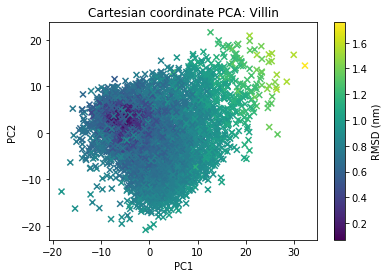

In [225]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0],
            reduced_cartesian[:, 1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')


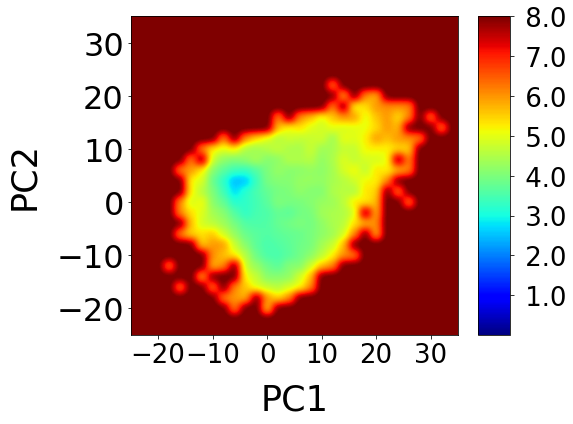

In [226]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


PC1 = reduced_cartesian[:, 0]
PC2 = reduced_cartesian[:, 1]

dG, xedges, yedges = free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plt.xlim(-25, 35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()


*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [227]:
# Lets Plot Free Energies as a function of RMSD and Rg
def free_energy1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


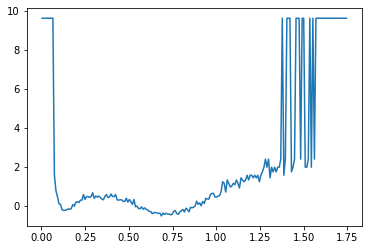

In [228]:
dG_RMSD, xedges = free_energy1D(rmsd, 300, 0, 1.75, 200)
plt.plot(xedges, dG_RMSD)


*** Potential homework ***

Visualize the lowest RMSD state

calculate quantity (SASA, coordination number)

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

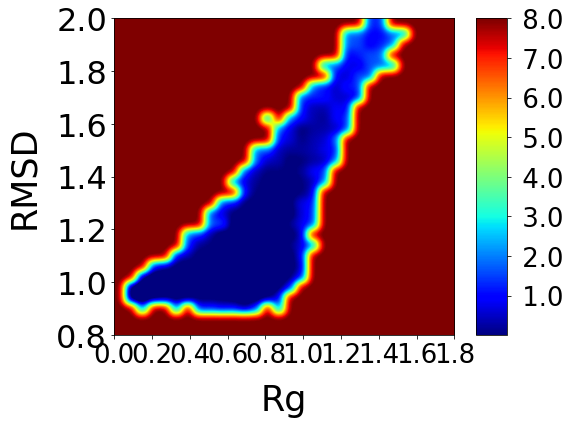

In [229]:
dG, xedges, yedges = free_energy(rg, rmsd, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()


In [230]:
# Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [231]:
# Lets Make Nice Contact Map Labels
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)

# Lets Zero Out some of the Labels
n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''


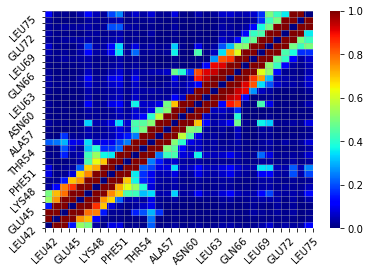

In [232]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0, cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 35))
ax.set_yticks(range(0, 35))
ax.set_xticklabels(sequence[:35], rotation=45)
ax.set_yticklabels(sequence[:35], rotation=45)
plt.show()


In [233]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)), np.sum(np.cos(angle)))


def circular_corr(angle1, angle2):
    cmean1 = circular_mean(angle1)
    cmean2 = circular_mean(angle2)
    numerator = (np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom = ((np.sum(np.sin(angle1-cmean1)**2) *
             np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor = numerator/denom
    return ccor


In [234]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi = dihedral_dict['phi'][i]
        psi = dihedral_dict['psi'][j]
        ccor = circular_corr(psi, phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)


(34, 34)

In [235]:
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc = sequence[1:34]
# Lets Zero Out some of the Labels
n = 2
for i in range(0, 33):
    if (i % n != 0):
        seq_trunc[i] = ''


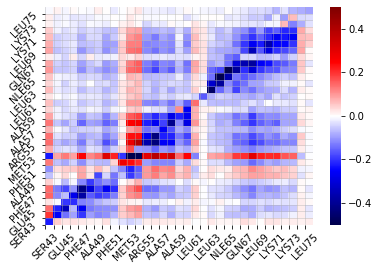

In [236]:
mask = np.zeros_like(final_map)
zeros = np.where((final_map < 0.10) & (final_map > -0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5, cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 33))
ax.set_yticks(range(0, 33))
ax.set_xticklabels(seq_trunc, rotation=45)
ax.set_yticklabels(seq_trunc, rotation=45)
plt.show()


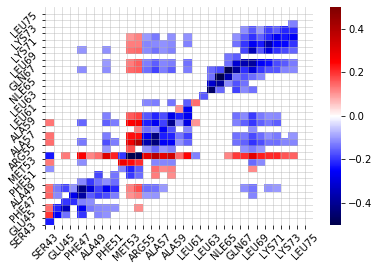

In [237]:
mask = np.zeros_like(final_cor_map)
zeros = np.where((final_cor_map < 0.10) & (final_cor_map > -0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, mask=mask, vmin=-0.5, vmax=0.5, cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 33))
ax.set_yticks(range(0, 33))
ax.set_xticklabels(seq_trunc, rotation=45)
ax.set_yticklabels(seq_trunc, rotation=45)
plt.show()


We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

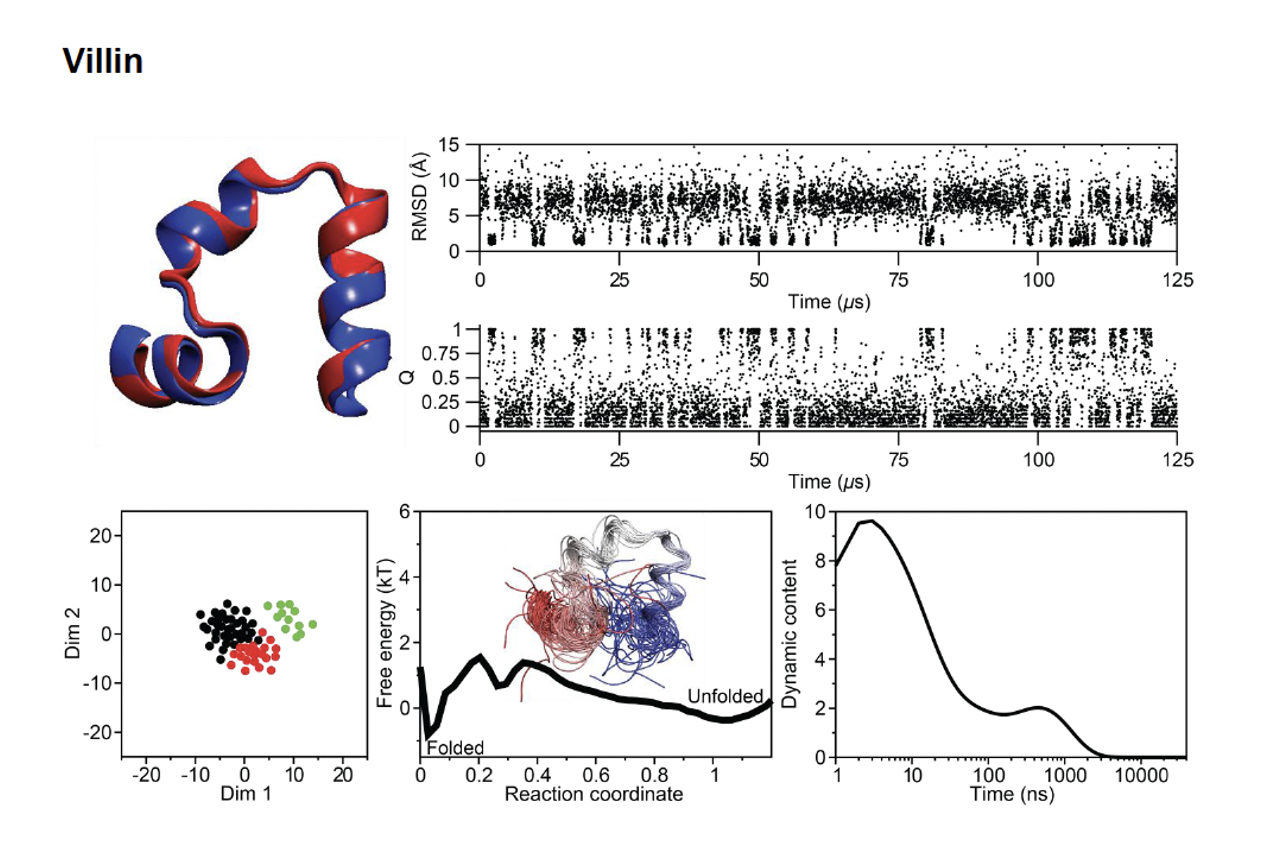

First we need to determine the native contacts and calculate Q

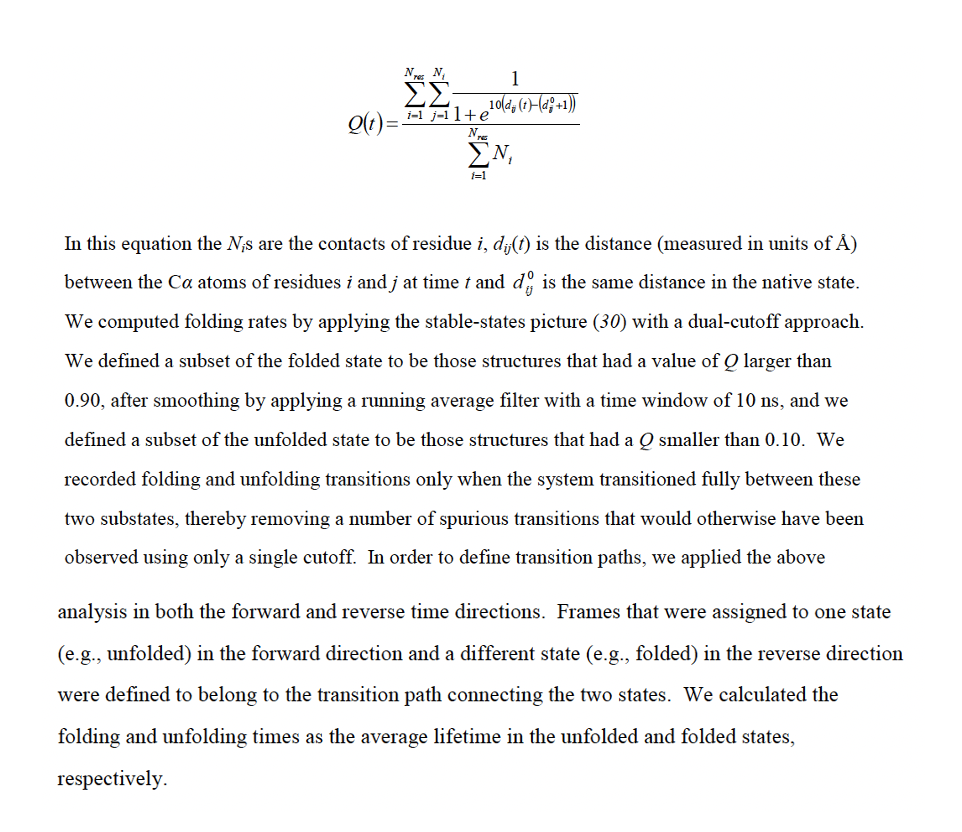

In [238]:
# Lets Make a 1D array that contains all native distances pairs:
xray_CA


<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x7fe5f55dacc0>

In [239]:
# Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D = []
# QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residuyes
for i in range(0, 35):
    for j in range(0, 35):
        if abs(i-j) > 7:
            dist = md.compute_distances(xray_CA, [[i, j]])[0]
            native_distance_matrix1D.append(dist[0])

# It's in nanometer
# Convert to Angstrom
native_distance_matrix1D = np.asarray(native_distance_matrix1D)*10
np.shape(native_distance_matrix1D)


(756,)

In [240]:
# Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory
traj_CA_distance_matrix1D = []
for i in range(0, 35):
    for j in range(0, 35):
        if abs(i-j) > 7:
            dist = md.compute_distances(trjCA, [[i, j]])[:, 0]
            traj_CA_distance_matrix1D.append(dist)

# Convert to Angstrom
traj_CA_distance_matrix1D = np.asarray(traj_CA_distance_matrix1D)*10
np.shape(traj_CA_distance_matrix1D)


(756, 6280)

In [241]:
traj_CA_native = traj_CA_distance_matrix1D[:, native_frames]
traj_native_average = np.average(
    traj_CA_distance_matrix1D[:, native_frames], axis=1)

native_contact_indices = np.where(traj_native_average < 10)
Native_Contacts_Trj_Dist = traj_CA_distance_matrix1D[native_contact_indices]
Native_Contacts_Xray_Dist = native_distance_matrix1D[native_contact_indices]


In [242]:
# Make Sure that For each Distance you can compare that native distance to the trajectory distance
for i in range(len(Native_Contacts_Xray_Dist)):
    print(Native_Contacts_Xray_Dist[i], Native_Contacts_Trj_Dist[i])


9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

In [243]:
Native_Contacts_Trj_Dist_T = Native_Contacts_Trj_Dist.T
Native_Contacts_Trj_Dist_T.shape


(6280, 46)

### Question 1

In [244]:
# Write a function to Calculate Q
def cal_Q(xray, traj):
    Q = []
    for i in range(len(traj)):
        q = np.sum((1/(1+np.exp(10*(traj[i]-(xray+1))))))/len(xray)
        Q.append(q)
    return Q


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


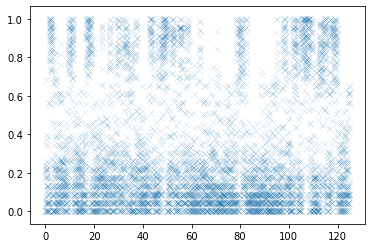

(array([2251., 1130.,  713.,  356.,  167.,  145.,  230.,  279.,  428.,
         581.]),
 array([2.58404748e-36, 9.99971887e-02, 1.99994377e-01, 2.99991566e-01,
        3.99988755e-01, 4.99985944e-01, 5.99983132e-01, 6.99980321e-01,
        7.99977510e-01, 8.99974699e-01, 9.99971887e-01]),
 <a list of 10 Patch objects>)

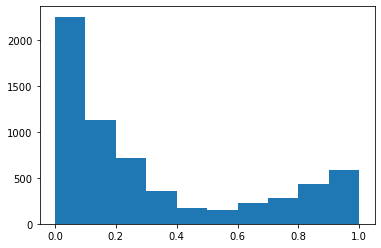

In [245]:
Q = []
for i in range(trj.n_frames):
    q = np.sum(1/(1+np.exp(10*(Native_Contacts_Trj_Dist_T[i]-(
        Native_Contacts_Xray_Dist+1)))))/Native_Contacts_Trj_Dist_T.shape[1]
    Q.append(q)
plt.scatter(time, np.array(Q), marker='x', linewidth=0.1)
plt.show()
plt.clf()
plt.hist(np.array(Q), bins=10)


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


(array([2251., 1130.,  713.,  356.,  167.,  145.,  230.,  279.,  428.,
         581.]),
 array([2.58404748e-36, 9.99971887e-02, 1.99994377e-01, 2.99991566e-01,
        3.99988755e-01, 4.99985944e-01, 5.99983132e-01, 6.99980321e-01,
        7.99977510e-01, 8.99974699e-01, 9.99971887e-01]),
 <a list of 10 Patch objects>)

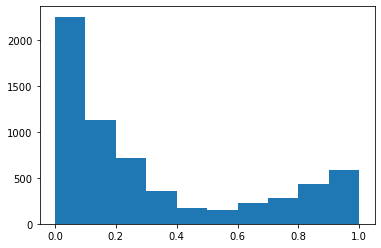

In [246]:
# Plot Q and a Histogram
Q = cal_Q(Native_Contacts_Xray_Dist, Native_Contacts_Trj_Dist_T)
plt.hist(np.array(Q), bins=10)


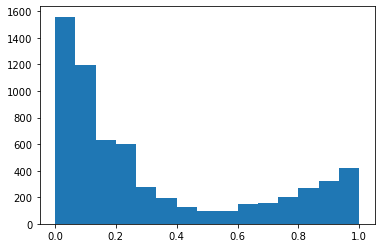

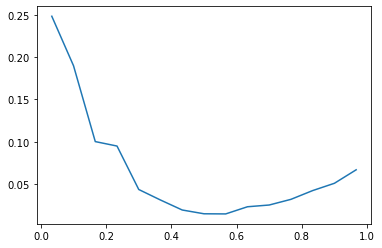

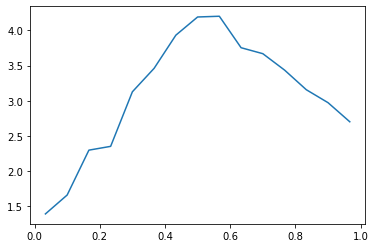

In [247]:
bins = 15
f = plt.hist(np.array(Q), bins=bins)[0]
f[f == 0] = .01
f = f/len(Q)
centers_ = np.linspace(0, 1, bins+1)
centers = centers_[1:] - np.diff(centers_)/2
e = -np.log(f)
plt.figure()
plt.plot(centers, f)
plt.figure()
plt.plot(centers, e)


### Question 2

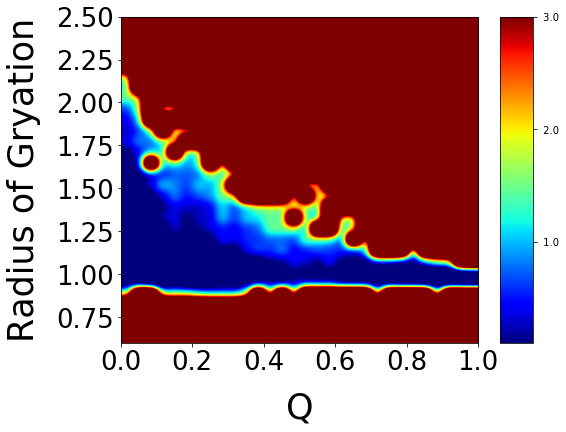

In [248]:
# Plot some 2D free energy surfaces (Q vs. Rg) (Advanced: Plot Q vs. Fraction Helix)
a, xedges, yedges = np.histogram2d(
    rg, Q, 30, [[0.6, 2.5], [0, 1.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)


(29, 6280)


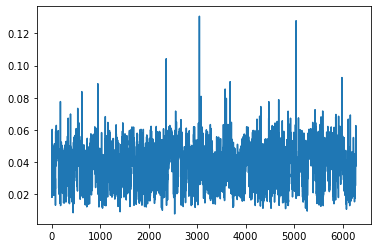

In [249]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa = (1.0-(RMS/r0)**8)/(1-(RMS/r0)**12)
    return Sa


helixpdb = '/home/daisy/Documents/Chem_course/Chem101.6/Assignment4/helix_villan.pdb'
helix = md.load_pdb(helixpdb)
# trj_native = trj[native_frames]
# print(trj_native)
# Sa = calc_SA(trj_native, helix, 1, 30)
Sa = calc_SA(trj, helix, 1, 30)
print(np.shape(Sa))
Sa_total = np.sum(Sa, axis=0)
plt.plot(Sa_total)


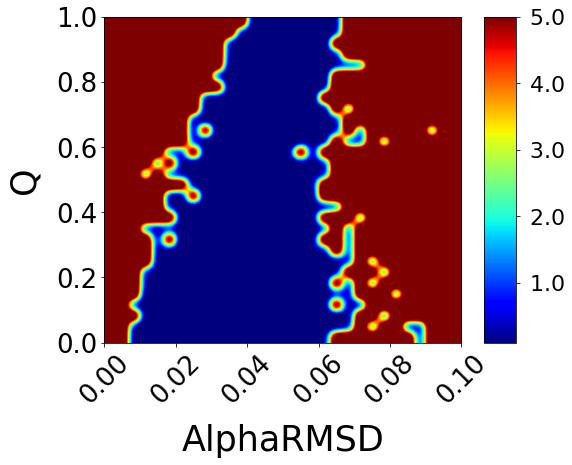

In [251]:
a, xedges, yedges = np.histogram2d(
    Q, Sa_total, 30, [[0.0, 1.0], [0.0, 0.1]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
# plt.xlim(0, 1)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Q", size=35, labelpad=15)
plt.xlabel("AlphaRMSD", size=35, labelpad=15)
plt.xticks(rotation=45, size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=5.0)
cb.ax.tick_params(labelsize=22)


### Question 3


Let's define dual cut-off of Q to be 0.3 and 0.8

### Question 4

In [266]:
# Cut-off used: 0.3 and 0.8
states = []
for i in Q:
    if i <= 0.3:
        states.append('U')
    elif i < 0.8:
        states.append('T')
    elif i >= 0.8:
        states.append('F')

reverse_states = states[::-1]

transition = []
for i in range(len(states)):
    if (states[i] == 'U' and reverse_states[i] == 'F') or (states[i] == 'F' and reverse_states[i] == 'U'):
        transition.append(1)
    else:
        transition.append(0)
        
print('Total transition happening: ' + str(np.sum(transition)))     


Total transition happening: 1314


### Question 5

In [267]:
fold_index = []
transition_index = []
unfold_index = []

for i in range(len(Q)):
    if Q[i] <= 0.3:
        unfold_index.append(i)
    elif Q[i] < 0.8:
        transition_index.append(i)
    elif Q[i] >= 0.8:
        fold_index.append(i)

fold_trj = trj[fold_index]
transition_trj = trj[transition_index]
unfold_trj = trj[unfold_index]
print(fold_trj)
print(transition_trj)
print(unfold_trj)

<mdtraj.Trajectory with 1009 frames, 577 atoms, 70 residues, and unitcells>
<mdtraj.Trajectory with 1177 frames, 577 atoms, 70 residues, and unitcells>
<mdtraj.Trajectory with 4094 frames, 577 atoms, 70 residues, and unitcells>


In [270]:
def make_contact_map(trj, name):
    plt.clf()
    contact_maps = []
    for i in range(0, 34):
        contact_map_major = []
        for j in range(0, 34):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(trj, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                contact = np.where(array < 0.5, 1, 0)
                contacts = np.average(contact)
            contact_map_major.append(contacts)
        contact_maps.append(contact_map_major)
    final_map = np.asarray(contact_maps).astype(float)
             
    ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0, cmap='jet')
    ax.invert_yaxis()
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0, 35))
    ax.set_yticks(range(0, 35))
    ax.set_xticklabels(sequence[:35], rotation=45)
    ax.set_yticklabels(sequence[:35], rotation=45)
    ax.set_title(name)
    plt.show()

# Lets Make Nice Contact Map Labels
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)

# Lets Zero Out some of the Labels
n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''

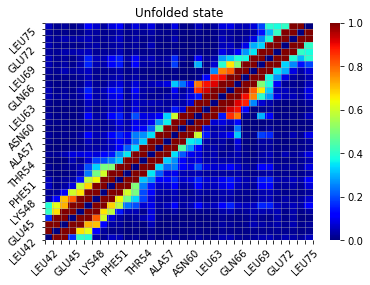

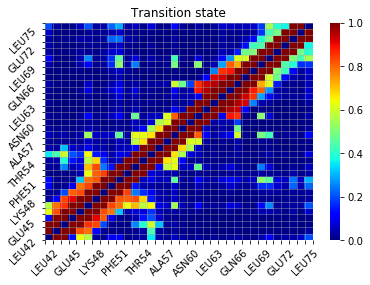

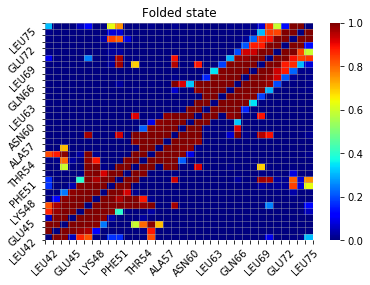

In [273]:
make_contact_map(unfold_trj, "Unfolded state")
make_contact_map(transition_trj, "Transition state")
make_contact_map(fold_trj, "Folded state")


In [272]:
def make_corr_map(trj, name):
    plt.clf()
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    indices_chi1, chi1s = md.compute_chi1(trj)
    indices_chi2, chi2s = md.compute_chi2(trj)

    dihedral_dict = {'phi': {},
                    'psi': {},
                    'chi1': {},
                    'chi2': {}}

    for i in range(0, len(indices_phi)):
        indices = indices_phi[i]
        atom = top.atom(indices[1])
        resnum = top.atom(indices[1]).residue.resSeq
        dihedral_dict['phi'][resnum] = phis[:, i]

    for i in range(0, len(indices_psi)):
        indices = indices_psi[i]
        atom = top.atom(indices[1])
        resnum = top.atom(indices[1]).residue.resSeq
        dihedral_dict['psi'][resnum] = psis[:, i]

    for i in range(0, len(indices_chi1)):
        indices = indices_chi1[i]
        atom = top.atom(indices[1])
        resnum = top.atom(indices[1]).residue.resSeq
        dihedral_dict['chi1'][resnum] = chi1s[:, i]

    for i in range(0, len(indices_chi2)):
        indices = indices_chi2[i]
        atom = top.atom(indices[1])
        resnum = top.atom(indices[1]).residue.resSeq
        dihedral_dict['chi2'][resnum] = chi2s[:, i]

    correlation_maps = []
    for i in range(43, 76):
        cor_map = []
        for j in range(43, 76):
            phi = dihedral_dict['phi'][i]
            psi = dihedral_dict['psi'][j]
            ccor = circular_corr(psi, phi)
            cor_map.append(ccor)
        correlation_maps.append(cor_map)
    final_cor_map = np.asarray(correlation_maps).astype(float)
    
    mask = np.zeros_like(final_map)
    zeros = np.where((final_map < 0.10) & (final_map > -0.10))
    mask[zeros] = True
    ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5, cmap='seismic')
    ax.invert_yaxis()
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0, 33))
    ax.set_yticks(range(0, 33))
    ax.set_xticklabels(seq_trunc, rotation=45)
    ax.set_yticklabels(seq_trunc, rotation=45)
    ax.set_title(name)
    plt.show()


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]


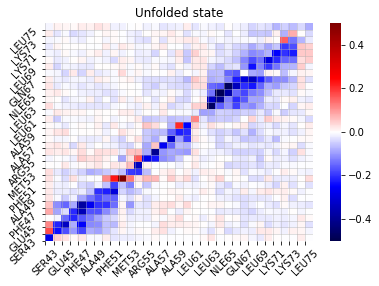

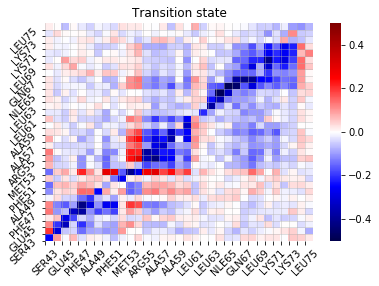

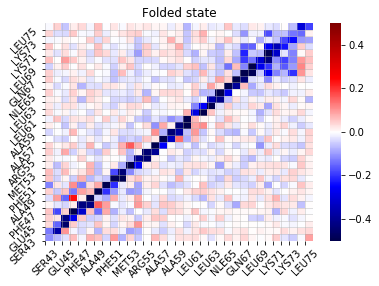

In [274]:
make_corr_map(unfold_trj, "Unfolded state")
make_corr_map(transition_trj, "Transition state")
make_corr_map(fold_trj, "Folded state")


In [287]:
def make_dssp(trj, name):
    xray_CA = md.load_pdb(xray_CA_pdb)
    top_xray = xray_CA.topology
    top_xray
    residue_xray = []
    for res in top_xray.residues:
        residue_xray.append(res.resSeq)
    resid_xray = np.asarray(residue_xray)
    
    plt.clf()
    dssp = md.compute_dssp(trj, simplified=True)
    
    Hprop, Eprop = dssp_convert(dssp)
    plt.plot(resid_xray, Hprop, c='r', label='helix')
    plt.plot(resid_xray, Eprop, c='b', label='sheet')

    plt.legend(loc="upper left")
    plt.xlabel('Residue', size=18)
    plt.ylabel('Secondary Strcture Fraction', size=18)
    plt.tick_params(labelsize=18)
    plt.title(name)
    plt.ylim(0,1)
    plt.show()



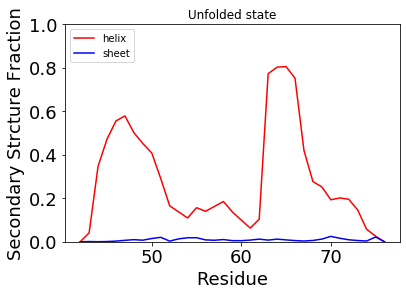

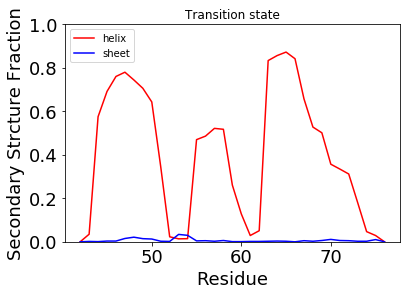

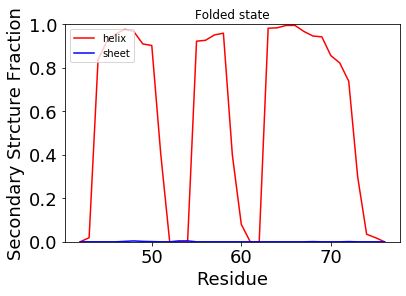

In [288]:
make_dssp(trjBB[unfold_index], "Unfolded state")
make_dssp(trjBB[transition_index], "Transition state")
make_dssp(trjBB[fold_index], "Folded state")